In [37]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt
import math
import scipy.stats as st
import pandas as pd
from matplotlib.colors import LogNorm

In [39]:
def dynamic_spectrum(segment, fps, f_range=(2, 40), num_freqs=100):
    """
    Compute a wavelet spectrogram of a signal segment 
    
    Parameters:
        segment: 1D numpy array (signal trace for a single trial)
        fps: frames per second (sampling rate)
        f_range: frequency range (Hz)
        num_freqs: number of frequency bins (log spaced)
        time_bandwidth: MATLAB-like 'TimeBandwidth' parameter
        voices_per_octave: MATLAB-like 'VoicesPerOctave' parameter

    Returns:
        power: normalized wavelet magnitude (freq x time)
        freqs: corresponding frequencies in Hz
    """
    dt = 1 / fps
    freqs = np.logspace(np.log10(f_range[0]), np.log10(f_range[1]), num_freqs)
    
    # Morelet wavelet
    wavelet = 'cmor2.0-1.0'
    
    # Match MATLAB scale construction
    scales = pywt.scale2frequency(wavelet, 1.0) / freqs * fps

    # Compute wavelet transform
    coeffs, actual_freqs = pywt.cwt(segment, scales, wavelet, sampling_period=dt)
    
    # Normalize as MATLAB: abs(wt) / sqrt(freq)
    amplitude = np.abs(coeffs) / np.sqrt(actual_freqs[:, np.newaxis])
    
    return amplitude, actual_freqs

In [ ]:
def plot_mouse_mean_spectra(mouse_name, all_results, logscale=False, common_color_scale=True):
    trial_type_names = ['HC Hit', 'HC Miss', 
                        'MC Hit', 'MC Miss', 'MC No Report',
                        'False Alarm', 'Correct Rejection', 'LC No Report']

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    axs = axs.flatten()

    vmin, vmax = None, None
    if common_color_scale and logscale:
        # Work in log space for percentile scaling
        logvals = []
        for tt in trial_type_names:
            data = all_results[mouse_name][tt]["MeanDynamicSpectrum"]
            data = data[np.isfinite(data) & (data > 0)]  # exclude zeros/NaNs
            logvals.append(np.log10(data))
        all_logvals = np.concatenate(logvals)
        log_min = np.percentile(all_logvals, 2)
        log_max = np.percentile(all_logvals, 98)

        # Ensure minimum dynamic range
        # min_log_range_ratio=100
        # if log_max - log_min < np.log10(min_log_range_ratio):
        #     log_min = log_max - np.log10(min_log_range_ratio)

        vmin = 10**log_min
        vmax = 10**log_max

    elif common_color_scale and not logscale:
        # Linear scale percentiles
        all_vals = np.concatenate([
            all_results[mouse_name][tt]["MeanDynamicSpectrum"].flatten() 
            for tt in trial_type_names
        ])
        vmin = np.nanpercentile(all_vals, 2)
        vmax = np.nanpercentile(all_vals, 98)

    for i, trial_type in enumerate(trial_type_names):
        result = all_results[mouse_name][trial_type]
        ax = axs[i]

        power = result["MeanDynamicSpectrum"]
        freqs = result["Frequencies"]
        time_arr = result["Time"]
        n_valid = len(result["ValidTrialIDs"])

        T, F = np.meshgrid(time_arr, freqs)
        data = power * 100

        if logscale:
            # Avoid zero or negative values in log plot
            data[data <= 0] = np.nan
            norm = LogNorm(vmin=vmin, vmax=vmax)
            im = ax.pcolormesh(T, F, data, shading='auto', cmap='jet', norm=norm)
        else:
            im = ax.pcolormesh(T, F, data, shading='auto', cmap='jet', vmin=vmin, vmax=vmax)

        ax.set_title(f'{trial_type} ({n_valid} trials)')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)
    scale_type = 'Log Scaled' if logscale else 'Linear Scale'
    plt.suptitle(f"Mean Dynamic Spectra for {mouse_name} ({scale_type})", fontsize=16)
    #plt.savefig(f'dynamic_spectra_cfm002')
    plt.show()

In [41]:
def plot_spectra_grid(power_list, freqs, time_arr, trial_ids, title, outliers=None):
    cols = 4
    rows = math.ceil(len(trial_ids) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16, 3 * rows), constrained_layout=True)
    axs = axs.flatten()

    for i, (tid, power) in enumerate(zip(trial_ids, power_list)):
        T, F = np.meshgrid(time_arr, freqs)
        im = axs[i].pcolormesh(T, F, power * 100, shading='auto', cmap='jet')
        axs[i].set_title(f"{tid[17:]}" + (" (Outlier)" if outliers and tid in outliers else ""))
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Freq (Hz)")
        cbar = fig.colorbar(im, ax=axs[i])
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)

    for ax in axs[len(trial_ids):]:
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [42]:
def process_trial_type(mouse_name, trial_type, outlier_std=2.5, plot=False, plot_all=False):
    with h5py.File(f'C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/results/cfm002_dynamic_spec_denoised_2.h5', 'r') as h5f:
        group = h5f[trial_type]
        all_signals = group["TimeSignals"][:]
        trial_ids = [tid.decode() for tid in group.attrs["TrialIDs"]]
        expected_duration = 6

        # Estimate fps using first valid signal
        for sig in all_signals:
            if len(sig) >= expected_duration * 10:
                fps = len(sig) / expected_duration
                break
        expected_length = int(expected_duration * fps)

        # Pad short signals with NaN
        for i, signal in enumerate(all_signals):
            if len(signal) < expected_length:
                padded = np.full(expected_length, np.nan)
                padded[:len(signal)] = signal
                all_signals[i] = padded

        # Compute dynamic spectra
        all_power, total_powers = [], []
        for sig in all_signals:
            power, freqs = dynamic_spectrum(sig, fps)#, plot=False)
            all_power.append(power)
            total_powers.append(np.nansum(power))  # use nansum in case power has NaNs

        all_power = np.stack(all_power)
        total_powers = np.array(total_powers)
        time_arr = np.linspace(-2.0, 3.0, all_power.shape[2])

        # Initial mean and outlier detection
        mean_power_initial = np.nanmean(all_power, axis=0)

        med = np.median(total_powers)
        mad = st.median_abs_deviation(total_powers)
        mad_zscores = np.abs((total_powers - med) / (mad * 1.4826))
        outliers = [tid for tid, z in zip(trial_ids, mad_zscores) if z > outlier_std]

        # Influence testing
        final_outliers = []
        threshold = 0.1
        for i, tid in enumerate(trial_ids):
            if tid not in outliers:
                continue
            mask = np.arange(len(trial_ids)) != i
            mean_wo_trial = np.nanmean(all_power[mask], axis=0)
            rmse = np.sqrt(np.nanmean((mean_power_initial - mean_wo_trial) ** 2))
            rel_rmse = rmse / np.nanmean(mean_power_initial)
            if rel_rmse > threshold:
                final_outliers.append(tid)

        # Recompute clean mean
        non_outlier_indices = [i for i, tid in enumerate(trial_ids) if tid not in final_outliers]
        all_power_clean = all_power[non_outlier_indices]
        mean_power_clean = np.nanmean(all_power_clean, axis=0)

        if plot:
            T, F = np.meshgrid(time_arr, freqs)
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            for ax, mp, label in zip(axs, [mean_power_initial, mean_power_clean], ["Initial", "Cleaned"]):
                im = ax.pcolormesh(T, F, mp * 100, shading='auto', cmap='jet')
                fig.colorbar(im, ax=ax, label="Change of wavelet magnitude (%)")
                ax.set_xlabel("Time relative to stimulus (s)")
                ax.set_ylabel("Frequency (Hz)")
                ax.set_title(f"{label} Mean Dynamic Spectrum")
            fig.suptitle(f"Mean Dynamic Spectra for {mouse_name}: {trial_type}")
            plt.show()

            # Plot outlier spectra
            if final_outliers:
                outlier_indices = [i for i, tid in enumerate(trial_ids) if tid in final_outliers]
                plot_spectra_grid([all_power[i] for i in outlier_indices], freqs, time_arr,
                                  [trial_ids[i] for i in outlier_indices],
                                  title=f"Outlier Dynamic Spectra for {trial_type}", outliers=final_outliers)

            if plot_all:
                non_outlier_ids = [trial_ids[i] for i in non_outlier_indices]
                plot_spectra_grid([all_power[i] for i in non_outlier_indices], freqs, time_arr,
                                  non_outlier_ids, title=f"Non-Outlier Dynamic Spectra for {trial_type}", outliers=[])

        return {
            "ValidTrialIDs": trial_ids,
            "OutlierTrialIDs": final_outliers,
            "MeanDynamicSpectrum": mean_power_clean,
            "Frequencies": freqs,
            "Time": time_arr
        }

In [43]:
def plot_mouse_mean_spectra(mouse_name, all_results, logscale=False):
    trial_type_names = ['HC Hit', 'HC Miss', 
                        'MC Hit', 'MC Miss', 'MC No Report',
                        'False Alarm', 'Correct Rejection', 'LC No Report']

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    axs = axs.flatten()

    for i, trial_type in enumerate(trial_type_names):
        result = all_results[mouse_name][trial_type]
        ax = axs[i]

        power = result["MeanDynamicSpectrum"] * 100  # percent change
        freqs = result["Frequencies"]
        time_arr = result["Time"]
        n_valid = len(result["ValidTrialIDs"])

        T, F = np.meshgrid(time_arr, freqs)
        data = np.copy(power)

        # Mask invalid values for logscale
        if logscale:
            data[data <= 0] = np.nan

        # Compute local color scale
        finite_vals = data[np.isfinite(data)]
        if logscale:
            log_min = np.nanpercentile(np.log10(finite_vals), 2)
            log_max = np.nanpercentile(np.log10(finite_vals), 98)
            norm = LogNorm(vmin=10**log_min, vmax=10**log_max)
            print(f"{trial_type}: log10 range = {log_min:.2f} to {log_max:.2f}")
        else:
            vmin = np.nanpercentile(finite_vals, 2)
            vmax = np.nanpercentile(finite_vals, 98)
            norm = plt.Normalize(vmin=vmin, vmax=vmax)
            print(f"{trial_type}: linear range = {vmin:.2f} to {vmax:.2f}")

        # Plot with individual normalization
        im = ax.pcolormesh(T, F, data, shading='nearest', cmap='jet', norm=norm)

        ax.set_title(f'{trial_type} ({n_valid} trials)', fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")

        # Individual colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Power (% change)", fontsize=8)
        cbar.ax.tick_params(labelsize=8)

    scale_type = 'Log Scale' if logscale else 'Linear Scale'
    plt.suptitle(f"Mean Dynamic Spectra for {mouse_name} ({scale_type})", fontsize=16)
    plt.show()

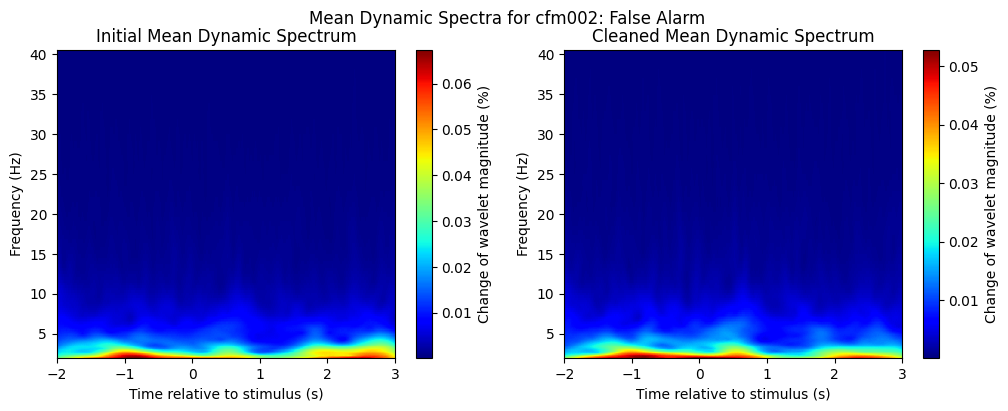

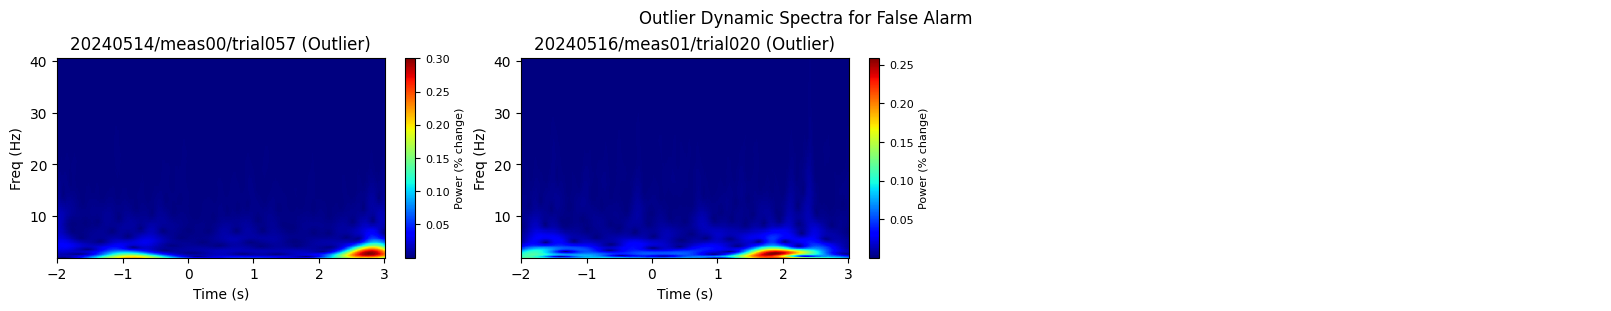

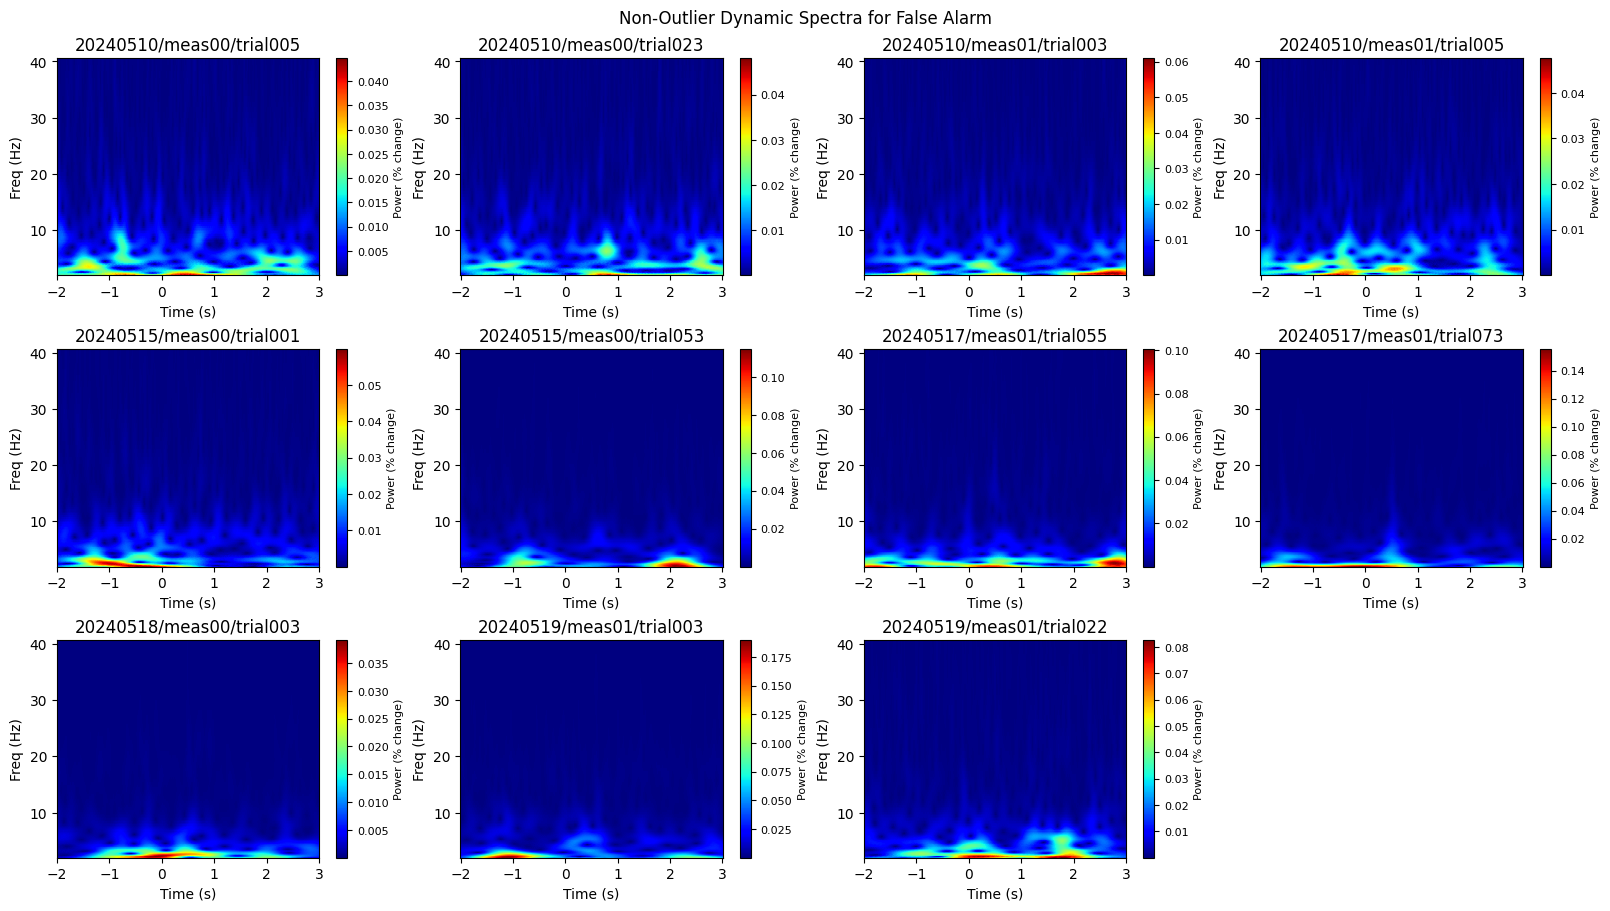

In [44]:
results = process_trial_type('cfm002', 'False Alarm', outlier_std=2.5, plot=True, plot_all=True)

In [45]:
trial_type_names = ['HC Hit', 'HC Miss', 
                    'MC Hit', 'MC Miss', 'MC No Report',
                    'False Alarm', 'Correct Rejection', 'LC No Report']
mouse_names = ['cfm002']#'cfm001', 'cfm002', 'cfm003', 'cmm001', 'cmm002', 'cmm003', 'rfm001', 'rfm002', 'rfm003']

all_results = {}

for mouse_name in mouse_names:
    all_results[mouse_name] = {} 
    for trial_type in trial_type_names:
        results = process_trial_type(mouse_name, trial_type, outlier_std=2.5, plot=False)
        all_results[mouse_name][trial_type] = results

HC Hit: log10 range = -3.59 to -1.24
HC Miss: log10 range = -3.58 to -1.16
MC Hit: log10 range = -3.60 to -1.22
MC Miss: log10 range = -3.60 to -1.20
MC No Report: log10 range = -3.57 to -1.16
False Alarm: log10 range = -3.62 to -1.36
Correct Rejection: log10 range = -3.59 to -1.26
LC No Report: log10 range = -3.57 to -1.17


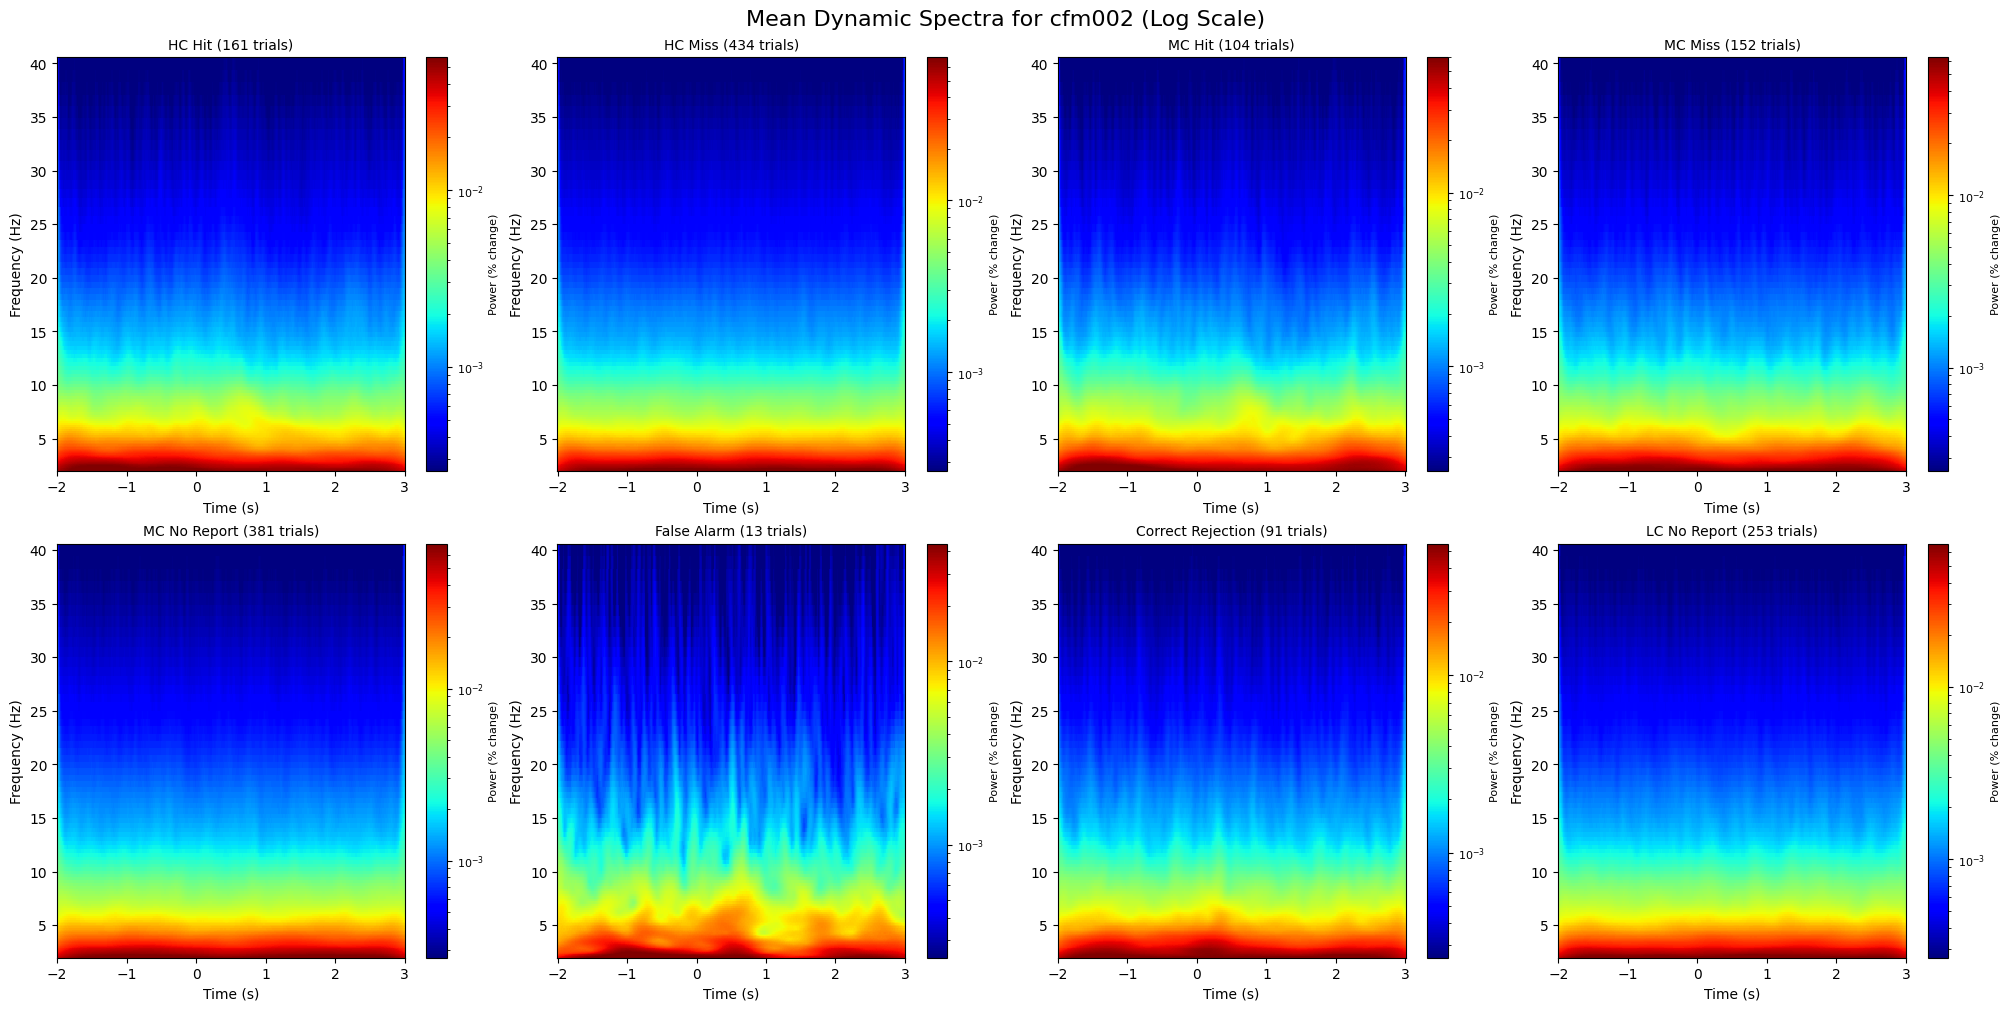

HC Hit: linear range = 0.00 to 0.06
HC Miss: linear range = 0.00 to 0.07
MC Hit: linear range = 0.00 to 0.06
MC Miss: linear range = 0.00 to 0.06
MC No Report: linear range = 0.00 to 0.07
False Alarm: linear range = 0.00 to 0.04
Correct Rejection: linear range = 0.00 to 0.06
LC No Report: linear range = 0.00 to 0.07


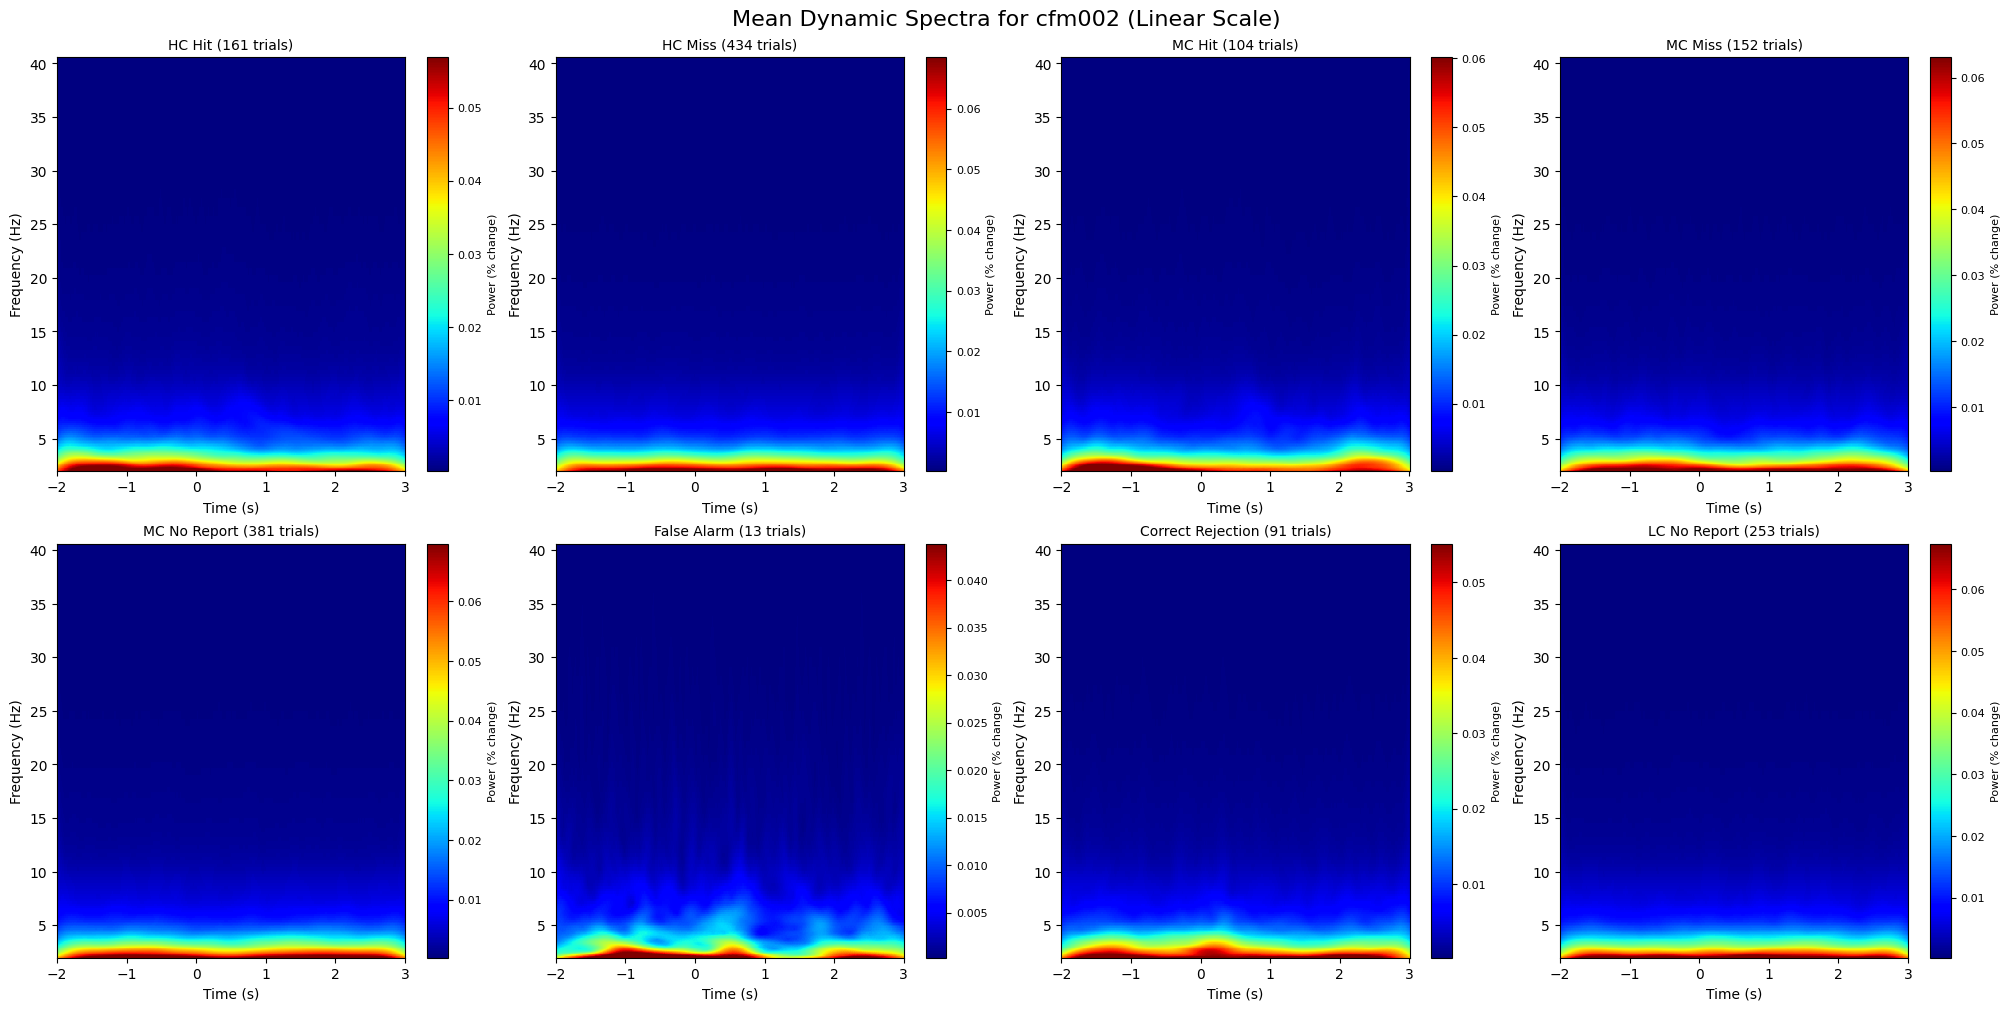

In [46]:
plot_mouse_mean_spectra('cfm002', all_results, logscale=True)
plot_mouse_mean_spectra('cfm002', all_results, logscale=False)

C:\Users\Katie\AppData\Local\Temp\ipykernel_14928\3865949296.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


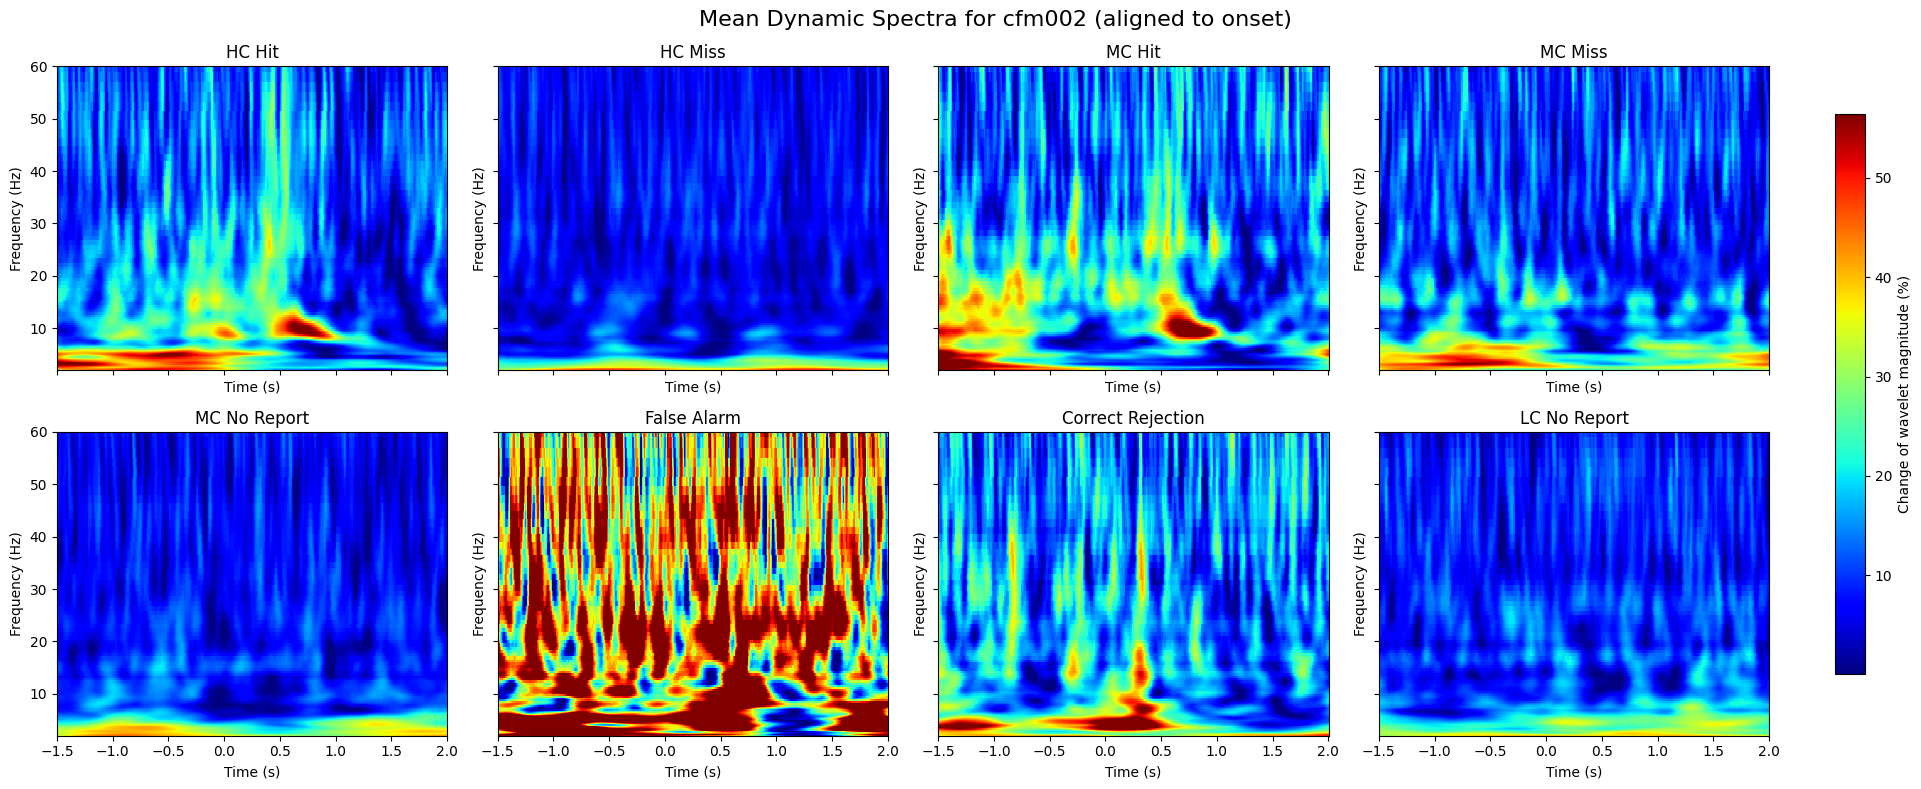

In [47]:
# Parameters
mouse_name = 'cfm002'
align_to = 'onset'
f_range = (2, 60)  # Frequency range to display
time_window = (-1.5, 2)  # Seconds
filename = f'results/{mouse_name}_dynamic_spec_denoised_2.h5'

# Trial types in same order as saved
trial_type_names = [
    'HC Hit', 'HC Miss',
    'MC Hit', 'MC Miss', 'MC No Report',
    'False Alarm', 'Correct Rejection', 'LC No Report'
]

# Step 1: Preload all spectra to determine global color limits
all_spectra = []
with h5py.File(filename, 'r') as h5f:
    for trial_type in trial_type_names:
        group = h5f[trial_type]
        wt_plot = group["MeanDynamicSpectrum"][()]
        time_axis = group.attrs["Time_Array"]

        # Mask to desired time window
        time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
        wt_plot_cut = wt_plot[:, time_mask]
        all_spectra.append(wt_plot_cut)

# Step 2: Compute shared color scale from all data
global_min, global_max = np.quantile(np.concatenate([s.flatten() for s in all_spectra]), [0.01, 0.95])

# Step 3: Plotting
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.ravel()

with h5py.File(filename, 'r') as h5f:
    for i, (trial_type, wt_plot_cut) in enumerate(zip(trial_type_names, all_spectra)):
        group = h5f[trial_type]
        freqs = group.attrs["Frequencies"]
        time_axis = group.attrs["Time_Array"]
        time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
        time_axis_cut = time_axis[time_mask]

        ax = axs[i]
        pcm = ax.pcolormesh(time_axis_cut, freqs, wt_plot_cut, shading='nearest', cmap='jet',
                            vmin=global_min, vmax=global_max)

        ax.set_title(trial_type, fontsize=12)
        ax.set_xlabel("Time (s)", fontsize=10)
        ax.set_ylabel("Frequency (Hz)", fontsize=10)
        ax.set_ylim(f_range)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # Position: [left, bottom, width, height]
fig.colorbar(pcm, cax=cbar_ax, label="Change of wavelet magnitude (%)")

fig.suptitle(f"Mean Dynamic Spectra for {mouse_name} (aligned to {align_to})", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()

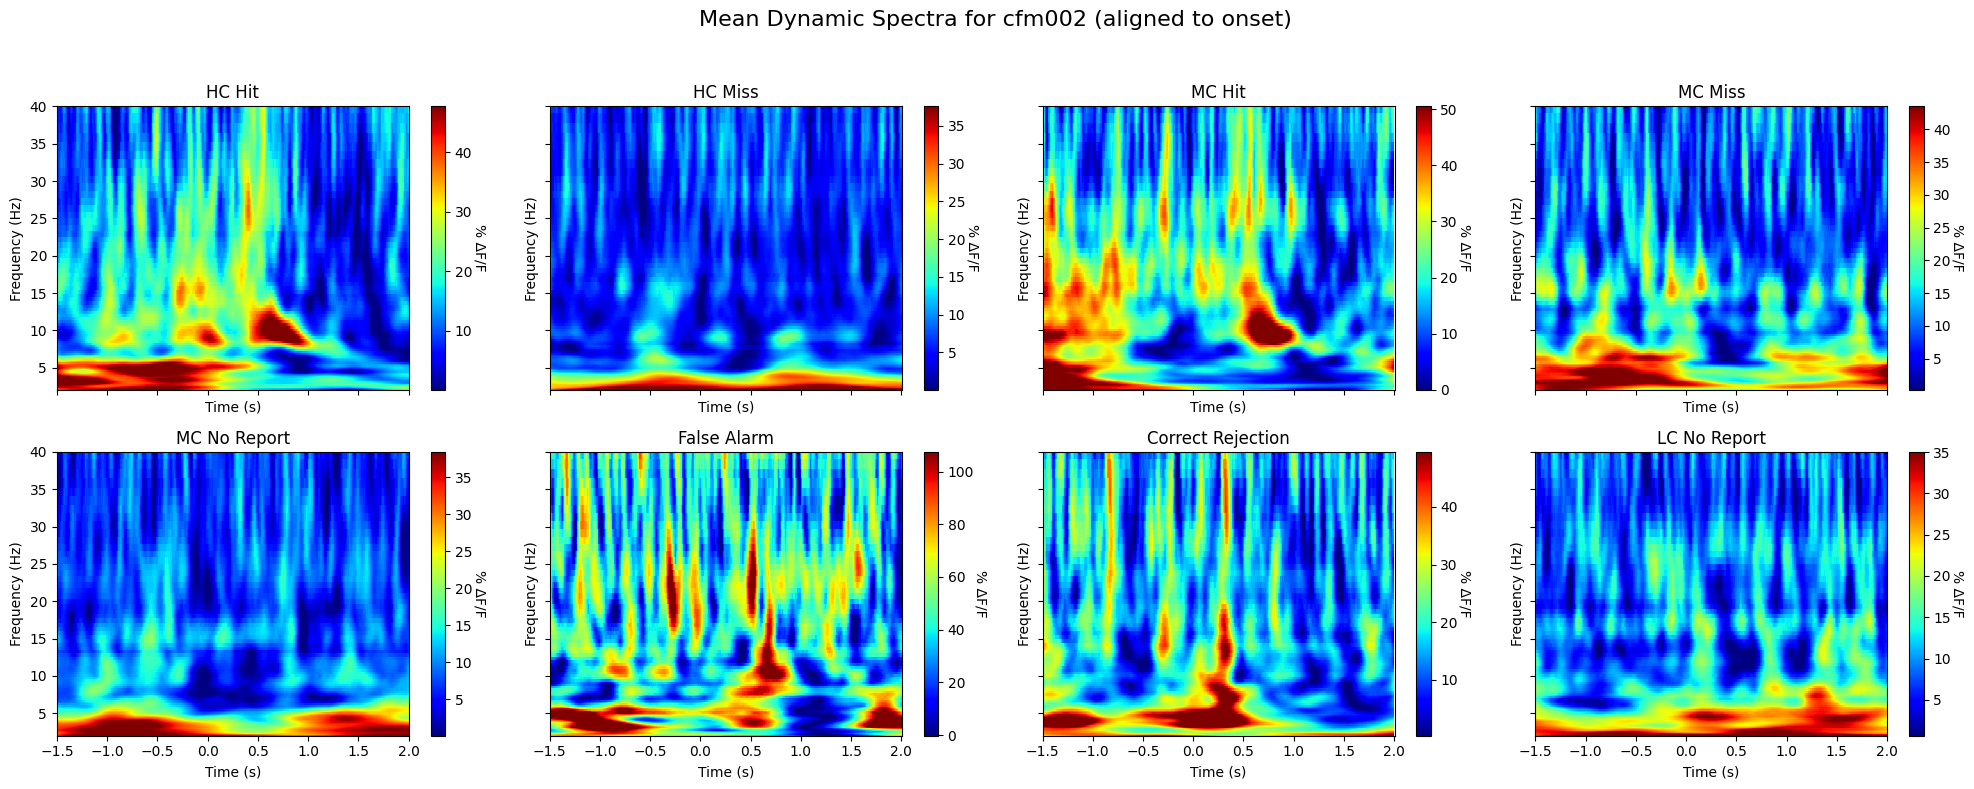

In [48]:
# Parameters
mouse_name = 'cfm002'
align_to = 'onset'
f_range = (2, 40)  # Frequency range to display
time_window = (-1.5, 2)  # Seconds
filename = f'results/{mouse_name}_dynamic_spec_denoised_2.h5'

# Trial types in same order as saved
trial_type_names = [
    'HC Hit', 'HC Miss',
    'MC Hit', 'MC Miss', 'MC No Report',
    'False Alarm', 'Correct Rejection', 'LC No Report'
]

# Load data
with h5py.File(filename, 'r') as h5f:
    fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
    axs = axs.ravel()

    for i, trial_type in enumerate(trial_type_names):
        group = h5f[trial_type]
        wt_plot = group["MeanDynamicSpectrum"][()]
        freqs = group.attrs["Frequencies"]
        time_axis = group.attrs["Time_Array"]
        
        # Restrict time range
        time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
        time_axis_cut = time_axis[time_mask]
        wt_plot_cut = wt_plot[:, time_mask]

        # Plotting
        ax = axs[i]
        cs = np.quantile(wt_plot_cut, [0.01, 0.95])
        pcm = ax.pcolormesh(time_axis_cut, freqs, wt_plot_cut, shading='auto', cmap='jet')
        pcm.set_clim(cs[0], cs[1])

        ax.set_title(trial_type, fontsize=12)
        ax.set_xlabel("Time (s)", fontsize=10)
        ax.set_ylabel("Frequency (Hz)", fontsize=10)
        ax.set_ylim(f_range)

        # Add individual colorbar to each subplot
        cbar = fig.colorbar(pcm, ax=ax)
        cbar.ax.set_ylabel("% ΔF/F", rotation=270, labelpad=10)

    fig.suptitle(f"Mean Dynamic Spectra for {mouse_name} (aligned to {align_to})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for title
    plt.show()

# What is up with my dynamic spectra???

In [49]:
def dynamic_spectrum(segment, fps, f_range=(2, 40), num_freqs=100):
    """
    Compute a wavelet spectrogram of a signal segment 
    
    Parameters:
        segment: 1D numpy array (signal trace for a single trial)
        fps: frames per second (sampling rate)
        f_range: frequency range (Hz)
        num_freqs: number of frequency bins (log spaced)

    Returns:
        power: normalized wavelet magnitude (freq x time)
        freqs: corresponding frequencies in Hz
    """
    dt = 1 / fps
    freqs = np.logspace(np.log10(f_range[0]), np.log10(f_range[1]), num_freqs)
    
    # Morelet wavelet
    wavelet = 'cmor2.0-1.0'
    
    # Match MATLAB scale construction
    scales = pywt.scale2frequency(wavelet, 1.0) / freqs * fps

    # Compute wavelet transform
    coeffs, actual_freqs = pywt.cwt(segment, scales, wavelet, sampling_period=dt)
    
    # Normalize as MATLAB: abs(wt) / sqrt(freq)
    amplitude = np.abs(coeffs) / np.sqrt(actual_freqs[:, np.newaxis])
    
    return amplitude, actual_freqs

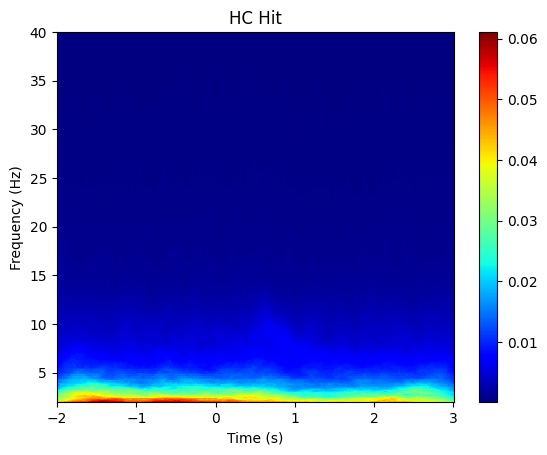

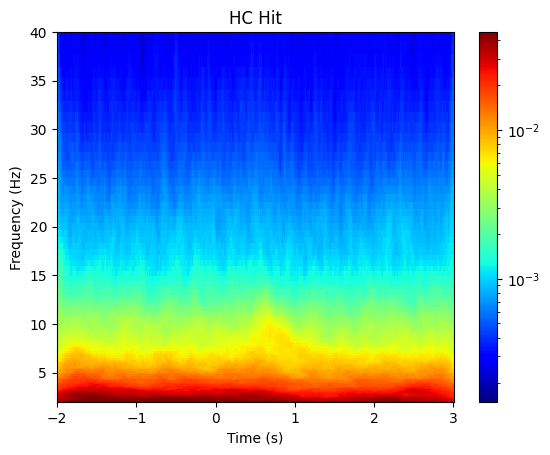

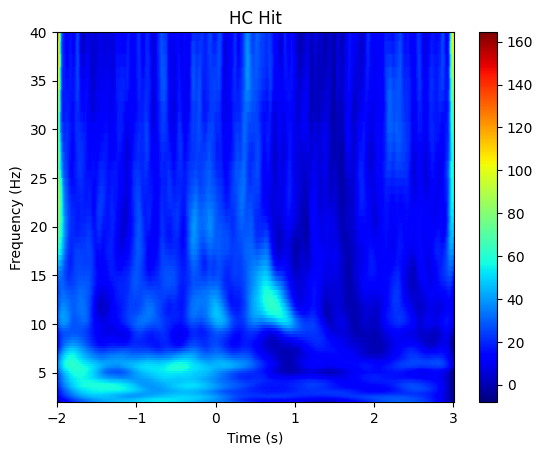

In [53]:
trial_type = 'HC Hit'
mouse_name = 'cfm002'
filename = f'results/{mouse_name}_dynamic_spec_denoised_2.h5'

all_power = []

with h5py.File(filename, 'r') as h5f:
    group = h5f[trial_type]
    ds = group["DynamicSpectra"]
    all_signals = group["TimeSignals"][()]
    freqs = group.attrs["Frequencies"]
    time_axis = group.attrs["Time_Array"]

    mean_ds = np.median(ds, axis=0)*100

    for signal in all_signals:
        fps = fps = len(signal) / 5
        power_norm, frequencies = dynamic_spectrum(signal, fps)
        all_power.append(power_norm)
    all_power = np.stack([arr for arr in all_power])
    mean_ds_2 = np.mean(all_power, axis=0)*100

plt.pcolormesh(time_axis, freqs, mean_ds, cmap='jet')
plt.xlabel('Time (s)')
plt.ylim((2,40))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.title(trial_type)
plt.show()

mean_ds = np.where(mean_ds > 0, mean_ds, np.nan)
plt.pcolormesh(time_axis, freqs, mean_ds, cmap='jet',
               norm=LogNorm(vmin=np.nanpercentile(mean_ds, 2), 
                            vmax=np.nanpercentile(mean_ds, 98)))
plt.xlabel('Time (s)')
plt.ylim((2,40))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.title(trial_type)
plt.show()

# Quantile normalization like MATLAB
q01 = np.quantile(mean_ds_2, 0.01, axis=1, keepdims=True)
q10 = np.quantile(mean_ds_2, 0.10, axis=1, keepdims=True)
mean_spectrogram = (mean_ds_2 - q01) / (q10 + 1e-10) * 100

plt.pcolormesh(time_axis, freqs, mean_spectrogram, cmap='jet')
plt.xlabel('Time (s)')
plt.ylim((2,40))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.title(trial_type)
plt.show()

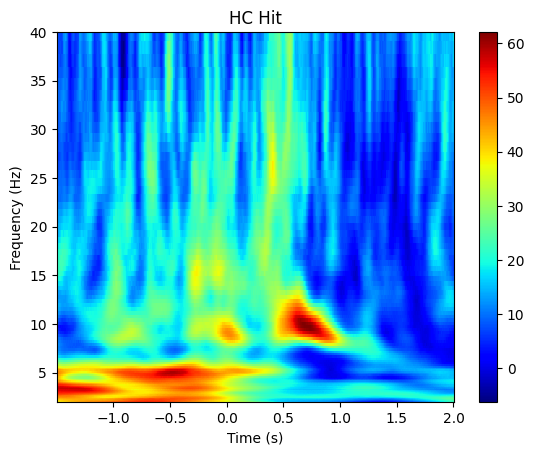

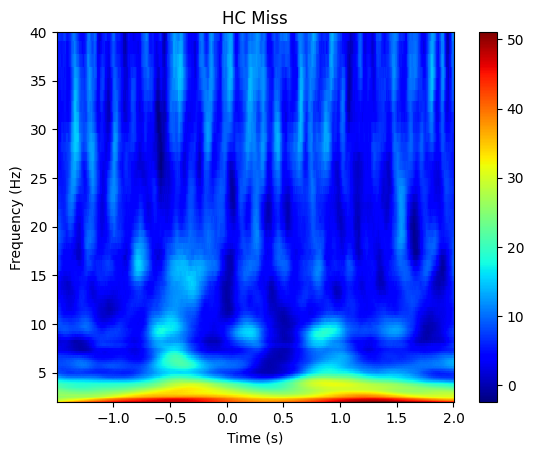

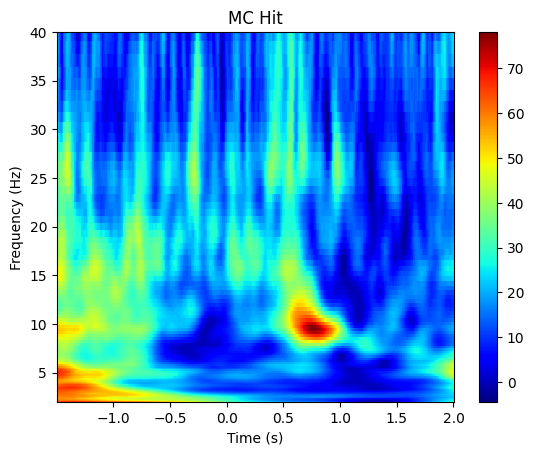

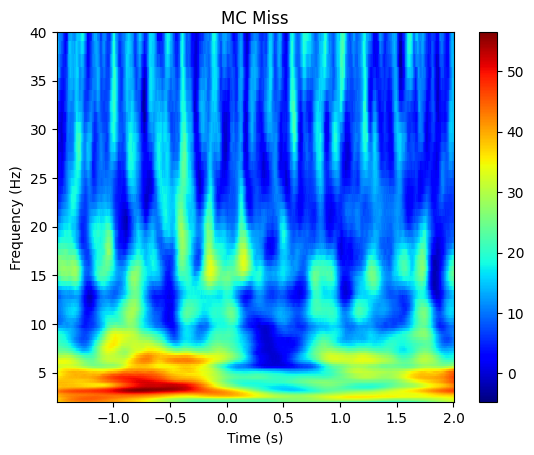

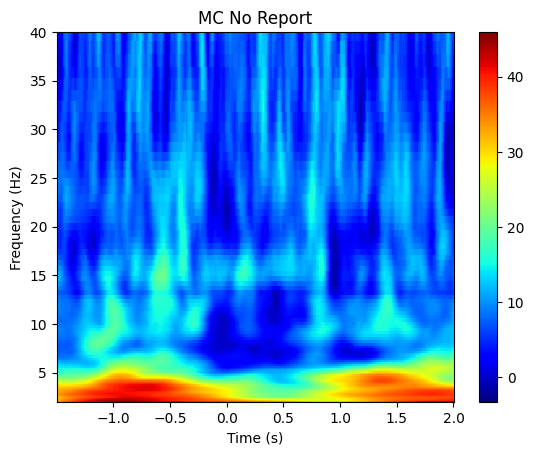

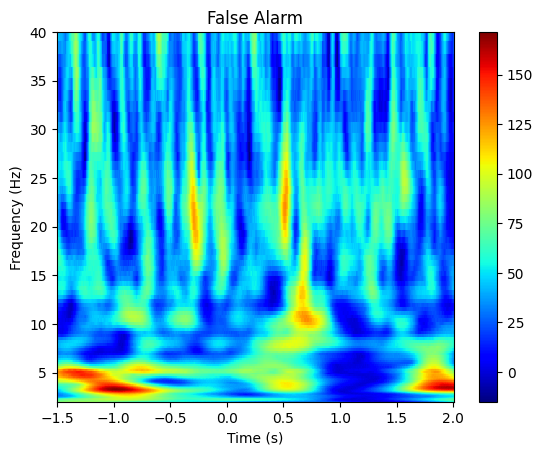

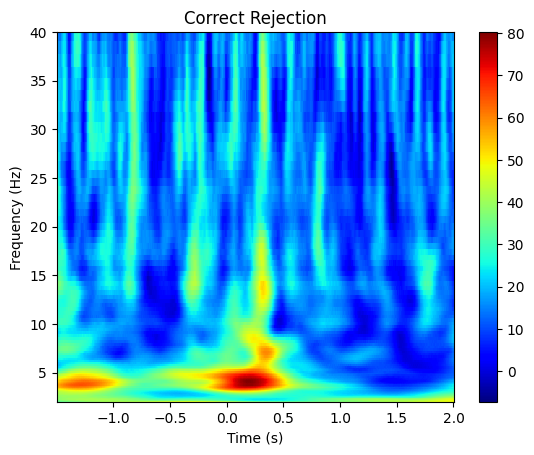

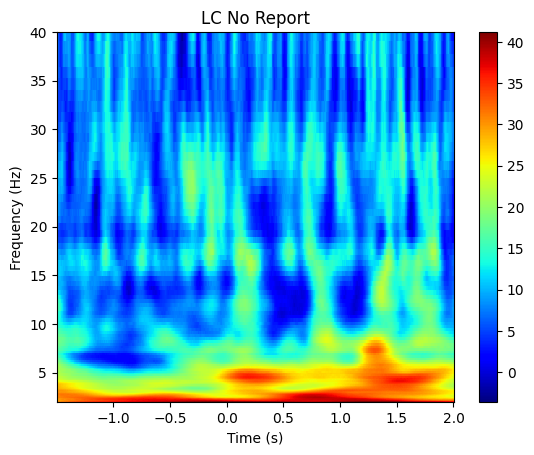

In [52]:
trial_type_names = ['HC Hit', 'HC Miss', 'MC Hit', 'MC Miss', 'MC No Report', 'False Alarm', 'Correct Rejection', 'LC No Report']
with h5py.File(filename, 'r') as h5f:
    for i, trial_type in enumerate(trial_type_names):
        group = h5f[trial_type]
        ds = group["MeanDynamicSpectrum"][()]
        freqs = group.attrs["Frequencies"]
        time_axis = group.attrs["Time_Array"]

        # Restrict time range
        time_window = (-1.5, 2)
        time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
        time_axis = time_axis[time_mask]
        ds = ds[:, time_mask]

        # Plot
        plt.pcolormesh(time_axis, freqs, ds, cmap='jet')
        plt.xlabel('Time (s)')
        plt.ylim((2,40))
        plt.ylabel('Frequency (Hz)')
        plt.colorbar()
        plt.title(trial_type)
        plt.show()